In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from __future__ import division
from scipy import stats
#sys.path = sys.path + ['/tank/home/vaggelis/anaconda2/bin/python']
#print(sys.path)
import scipy as sc
import cvxpy as cvp
from CSSS import CSSS
import time 
#import cvxopt as co
%matplotlib inline
print cvp.installed_solvers()
from decimal import *
import datetime
import pickle
import json

['MOSEK', 'ECOS_BB', 'SCS', 'ECOS', 'LS']


# Functions

In [2]:
## Organises X data from df in appropriate matrix form (Xhat) to support optimization with time-varying regressors
# The function assumes the the regressors are of the form Y_i = X_i * k_i + R_i, where k_i and R_i are scalars and i indicates one time window
# Matrix notation for all time windows: Y = Xhat * [R; k]. Structure of Xhat = [blkdiag(ones_vectors) | blkdiag(Xaux)]
# This version is WITHOUT weekday-weekend dependence
def buildMat(df,numD,dfName,normFact,windH,intercept):
    N=len(df)
    X = np.array(df[dfName]/normFact) # vector data to organize in appropriate form
    numW = len(windH) # number of windows
    Xbig = [[[] for i in range(numW)] for j in range(numD)]

    # Loop through X vector and create Xbig matrix
    initStep = pd.to_datetime(df['Unnamed: 0'].iloc[0])
    initDay = initStep.day

    for i in range(N):
        curStep = pd.to_datetime(df['Unnamed: 0'].iloc[i])
        curDay = curStep.day - initDay
        curHour = curStep.hour

        indices = np.where(curHour-np.array(windH)>=0)
        curWind = indices[0][len(indices[0])-1]

        Xbig[curDay][curWind].append(X[i])

    # Build Xhat matrix (which multiplies the vector of time-varying regressors) using Xbig
    for i in range(numD):
        Xaux = []
        for j in range(numW):
            tmp = np.array(Xbig[i][j]) 
            tmplen = len(tmp)
            tba = tmp.reshape((tmplen,1)) # to be added
            if j==0:
                Xaux = tba
                Iaux = np.ones((tmplen,1))
            else:       
                Xaux = sc.linalg.block_diag(Xaux,tba)
                Iaux = sc.linalg.block_diag(Iaux,np.ones((tmplen,1)))
        if i==0:
            Xtilda = Xaux
            Itilda = Iaux
        else:
            Xtilda = np.vstack((Xtilda,Xaux))
            Itilda = np.vstack((Itilda,Iaux))
    if (intercept):
        Xhat = np.hstack((Itilda,Xtilda))
    else:
        Xhat = Xtilda
    return Xhat


In [3]:
## Organises X data from df in appropriate matrix form (Xhat) to support optimization with time-varying regressors
# The function assumes the the regressors are of the form Y_i = X_i * k_i + R_i, where k_i and R_i are scalars and i indicates one time window
# Matrix notation for all time windows: Y = Xhat * [R; k]. Structure of Xhat = [blkdiag(ones_vectors) | blkdiag(Xaux)]
# This version is WITH weekday-weekend dependence
def buildMat2(df,numD,dfName,normFact,windH,intercept):
    N=len(df)
    X = np.array(df[dfName]/normFact) # vector data to organize in appropriate form
    numW = len(windH) # number of windows
    dayOfWeek = np.array(df['dayOfWeekIndex'])
    Xbig = [[[] for i in range(numW)] for j in range(numD)]
    dayOfWeekBig = [[[] for i in range(numW)] for j in range(numD)]

    # Loop through X vector and create Xbig matrix
    initStep = pd.to_datetime(df['Unnamed: 0'].iloc[0])
    initDay = initStep.day

    for i in range(N):
        curStep = pd.to_datetime(df['Unnamed: 0'].iloc[i])
        curDay = curStep.day - initDay
        curHour = curStep.hour

        indices = np.where(curHour-np.array(windH)>=0)
        curWind = indices[0][len(indices[0])-1]

        Xbig[curDay][curWind].append(X[i])
        dayOfWeekBig[curDay][curWind].append(dayOfWeek[i])

    # Build Xhat matrix (which multiplies the vector of time-varying regressors) using Xbig
    for i in range(numD):
        Xaux = []
        for j in range(numW):
            tmp = np.array(Xbig[i][j]) 
            tmplen = len(tmp)
            tba = tmp.reshape((tmplen,1)) # to be added
            if j==0:
                Xaux = tba
                Iaux = np.ones((tmplen,1))
            else:       
                Xaux = sc.linalg.block_diag(Xaux,tba)
                Iaux = sc.linalg.block_diag(Iaux,np.ones((tmplen,1)))
        Xaux2 = np.hstack((Xaux,np.zeros(Xaux.shape)))
        Iaux2 = np.hstack((Iaux,np.zeros(Iaux.shape)))
        Xaux3 = np.hstack((np.zeros(Xaux.shape),Xaux))
        Iaux3 = np.hstack((np.zeros(Iaux.shape),Iaux))
        
        if i==0:
            if ((dayOfWeekBig[i][j][0]!=5) and (dayOfWeekBig[i][j][0]!=6)): #weekdays
                Xtilda = Xaux2
                Itilda = Iaux2
            else: # weekends
                Xtilda = Xaux3
                Itilda = Iaux3
                                   
        else:
            if ((dayOfWeekBig[i][j][0]!=5) and (dayOfWeekBig[i][j][0]!=6)): #weekdays
                Xtilda = np.vstack((Xtilda,Xaux2))
                Itilda = np.vstack((Itilda,Iaux2))
            else:
                Xtilda = np.vstack((Xtilda,Xaux3))
                Itilda = np.vstack((Itilda,Iaux3))
    if (intercept):
        Xhat = np.hstack((Itilda,Xtilda))
    else:
        Xhat = Xtilda
    return Xhat


In [4]:
# Shorthand for adding standard constraints in the CSSS problem
def standardConst(df,csss,name1,name2):
    # Constrain Solar to be <= 0 . 
    csss.addConstraint(csss.models[name1]['source'] <= 0 )
    # Constrain Load to be >=0
    csss.addConstraint(csss.models[name2]['source'] >= 0 )
    # Constraint Solar to be 0, when solar proxy is 0
    irrProxy = df['IrradianceProxy']
    idx0 = np.where(irrProxy<1)[0]
    csss.addConstraint(csss.models[name1]['source'][idx0] == 0 )
    return csss    

# Shorthand for adding sign constraints for source signals in the CSSS problem
def signConst(csss,name1,name2):
    # Constrain Solar to be <= 0 . 
    csss.addConstraint(csss.models[name1]['source'] <= 0 )
    # Constrain Load to be >=0
    csss.addConstraint(csss.models[name2]['source'] >= 0 )
    return csss

# Shorthand for adding sign constraints for source signals and regressors in the CSSS problem
def signConst2(csss,name1,name2):
    # Constrain Solar to be <= 0 . 
    csss.addConstraint(csss.models[name1]['source'] <= 0 )
    # Constrain Load to be >=0
    csss.addConstraint(csss.models[name2]['source'] >= 0 )
    # Constrain solar regressors to be <= 0
    csss.addConstraint(csss.models[name1]['theta'] <= 0 )
    # Constrain load regressors to be >= 0
    csss.addConstraint(csss.models[name2]['theta'] >= 0 )
    return csss

# Sign constraints 2 + constrain some of the time-varying regressors to be constant
def signConst2AndRegConst(csss,name1,name2,regressor,linearThetaConst,intercThetaConst):
    # Constrain Solar to be <= 0 . 
    csss.addConstraint(csss.models[name1]['source'] <= 0 )
    # Constrain Load to be >=0
    csss.addConstraint(csss.models[name2]['source'] >= 0 )
    # Constrain solar regressors to be <= 0
    csss.addConstraint(csss.models[name1]['theta'] <= 0 )
    # Constrain load regressors to be >= 0
    csss.addConstraint(csss.models[name2]['theta'] >= 0 )
    # Constrain time-varying linear coefficients of load model to be equal
    nReg = regressor.shape[1]
    if nReg>=2:
        if (linearThetaConst):
            for i in range(int(nReg/2),int(nReg-1)):
                csss.addConstraint(csss.models[name2]['theta'][i]==csss.models[name2]['theta'][i+1])
        if (intercThetaConst):
            for i in range(int(nReg/2-1)):
                csss.addConstraint(csss.models[name2]['theta'][i]==csss.models[name2]['theta'][i+1]) 
    else:
        pass
    return csss

# Shorthand for collecting results from optimization
def collectRes(csss,name):
    res = []
    for val in csss.models[name]['source'].value:
        res.append(float(val))
    return res

# Filter only part of data during daytime (exclude night)
def excludeNight(df):
    irrProxy = df['IrradianceProxy']
    idx0 = np.where(irrProxy>=1)[0]
    df_new = df.iloc[idx0]
    return df_new

# Identify indices where the day change occurs --> relevant for source regularization
def findDayChng(df):
    dayIndex = df['DayIndex']
    idx = np.where(np.diff(dayIndex)!=0)[0]
    return idx

def getTestSet(df,testRatio,seed):
    dayIndex = df['DayIndex']
    firstDay = np.min(dayIndex)
    lastDay = np.max(dayIndex)
    numDays = lastDay-firstDay+1
    allDays = np.arange(firstDay,lastDay+1)
    numTestDays = int(np.ceil(testRatio*numDays))
    testSet = []
    np.random.seed(seed)
    for i in range(numTestDays):
        toInsert = int(np.round(np.random.uniform(firstDay,lastDay)))
        while toInsert in testSet:
            toInsert = int(np.round(np.random.uniform(firstDay,lastDay)))
        testSet.append(toInsert)
    trainSet = np.setdiff1d(allDays,testSet)
    return trainSet, np.sort(testSet)

# Split dataframe into training and validation set
def splitDFinto2DFs(df,trainSet,testSet):
    dayIndex = df['DayIndex']
    
    idxTrain = []
    for day in trainSet: 
        tmp = np.where(dayIndex==day)[0]
        idxTrain = np.concatenate((idxTrain,tmp))
    df_train = df.iloc[idxTrain]
    
    idxTest = []
    for day in testSet: 
        tmp = np.where(dayIndex==day)[0]
        idxTest = np.concatenate((idxTest,tmp))
    df_test = df.iloc[idxTest]
    return df_train, df_test 

# Find the hour indexes when solar irradiance is > 0
def minAndMaxPVhours(df):
    N=len(df)
    minHour = np.inf
    maxHour = -np.inf
    for i in range(N):
        curStep = pd.to_datetime(df['Unnamed: 0'].iloc[i])
        curHour = curStep.hour
        minHour = np.minimum(curHour,minHour)
        maxHour = np.maximum(curHour,maxHour)
    maxHour+=1
    return minHour,maxHour
    

In [5]:
## Error metric definitions
def mae(x,y):
    N = len(x)
    return (np.sum(np.absolute(y-x)))/N

def rmse(x,y):
    N = len(x)
    return np.sqrt((np.sum(np.square(y-x)))/N)

# Import the data for the distributed PV case

In [6]:
monthUsed = 'August' # 'January' or 'August'

if monthUsed == 'January':
    df = pd.read_csv('Sample_Jan_data.csv')
elif monthUsed == 'August':
    df = pd.read_csv('Sample_Aug_data.csv')

else:
    raise NameError('No suitable selection of month!')

df=df.dropna()
N=len(df)

# Reset index of power-data df to datetime --> relevant only when adding airport irradiance data
df['Time'] = pd.to_datetime(df['Unnamed: 0'])
df = df.reset_index().set_index('Time')

Pagg = np.array(df['Real_Power_Total'])
Qagg = np.array(df['Reactive_Power_Total'])
df['IrradianceProxy1']= df['System 4'] # PV system with South orientation as irradiance proxy
# df['IrradianceProxy1']= df['System 2'] # PV system with South-West orientation as irradiance proxy
# df['IrradianceProxy1']= df['System 1'] # PV system with South-East orientation as irradiance proxy
df['IrradianceProxy'] = df['IrradianceProxy1']

# Extend the data frame with a column that includes the day number
dayIndex = [pd.to_datetime(df['Unnamed: 0'].iloc[i]).day for i in range(len(df))] 
df['DayIndex'] = dayIndex

# Extend the data frame with a column that indicates the day of the week (6 is Sunday)
dayOfWeekIndex = pd.to_datetime(df['Unnamed: 0']).dt.dayofweek
df['dayOfWeekIndex'] = dayOfWeekIndex


In [7]:
# Create dataframe with orientations
dfOrient = pd.read_csv('Orientation_data.csv')

SWnum = len(dfOrient.loc[dfOrient['Orien']=='South;West'])
Snum = len(dfOrient.loc[dfOrient['Orien']=='South'])
Wnum = len(dfOrient.loc[dfOrient['Orien']=='West'])
WEnum = len(dfOrient.loc[dfOrient['Orien']=='West;East'])
SEnum = len(dfOrient.loc[dfOrient['Orien']=='South;East'])
Enum = len(dfOrient.loc[dfOrient['Orien']=='East'])
totnum = len(dfOrient)
print(SWnum,Snum,Wnum,WEnum,SEnum,Enum,np.sum([SWnum,Snum,Wnum,WEnum,SEnum,Enum]))


(19, 28, 0, 0, 26, 0, 73)


In [8]:
# Script to decide the orientations in each scenario of # of proxies
# assume list of proxies for case with N-1 proxies is known
# list for case with N proxies = 
# list for case with N-1 proxies 
# + 
# 1 new proxy sampled based on the discrete prob dist fun of S, SW and SE

recompproxyIDdict = False

if recompproxyIDdict:
    # Discrete prob distr for 3 most frequent orientations
    xk = np.arange(1,4)
    totnum = Snum+SWnum+SEnum
    pk = (Snum/totnum, SWnum/totnum, SEnum/totnum)
    custm = stats.rv_discrete(name='custm', values=(xk, pk))

    maxLen = 38 # corresponds to roughly 50% proxies (total number of PVs is 73)
    numOrien = 6
    allOK = False

    while allOK==False:
        proxyDict = {}
        listOfProxies = []
        for numProxy in range(1,maxLen+1):
            if numProxy<=numOrien:
                curProxy = numProxy        
            else:
                curProxy = int(custm.rvs(size=1))
            listOfProxies = listOfProxies + [curProxy]
            proxyDict.update([(numProxy, listOfProxies)])
        percentSW = len(np.where(np.array(listOfProxies)==1)[0])/(maxLen-numOrien)
        percentS = len(np.where(np.array(listOfProxies)==2)[0])/(maxLen-numOrien)
        if all(elem in listOfProxies  for elem in xk) & (percentSW<1.02*pk[0]) & (percentSW>0.98*pk[0]) & (percentS<1.02*pk[1]) & (percentSW>0.98*pk[1]):
            allOK = True
    #print(proxyDict) 
    #print(percentSW, pk[0]) # comparison of desired probability with achieved probability in the sample
    #print(percentS, pk[1])

    # Script to select the IDs of PVs for the proxy set (process repeated for each case of # of proxies)
    # Determinstic: select from the top of df until the necessary number is reached
    dfSW = dfOrient.loc[dfOrient['Orien']=='South;West']
    dfS = dfOrient.loc[dfOrient['Orien']=='South']
    dfW = dfOrient.loc[dfOrient['Orien']=='West']
    dfWE = dfOrient.loc[dfOrient['Orien']=='West;East']
    dfSE = dfOrient.loc[dfOrient['Orien']=='South;East']
    dfE = dfOrient.loc[dfOrient['Orien']=='East']

    proxyIDdict = {}
    for key in proxyDict.keys():
        curList = proxyDict[key]
        num1 = len(np.where(np.array(curList)==1)[0])
        num2 = len(np.where(np.array(curList)==2)[0])
        num3 = len(np.where(np.array(curList)==3)[0])
        num4 = len(np.where(np.array(curList)==4)[0])
        num5 = len(np.where(np.array(curList)==5)[0])
        num6 = len(np.where(np.array(curList)==6)[0])
        curListIDs = np.concatenate((np.array(dfSW['Unnamed: 0'].iloc[0:num1]),np.array(dfS['Unnamed: 0'].iloc[0:num2]),
                                    np.array(dfW['Unnamed: 0'].iloc[0:num3]),np.array(dfWE['Unnamed: 0'].iloc[0:num4]),
                                    np.array(dfSE['Unnamed: 0'].iloc[0:num5]),np.array(dfE['Unnamed: 0'].iloc[0:num6])))
        proxyIDdict.update([(key,curListIDs)])
    #print(proxyIDdict)
    pickle_out = open("proxyIDdict.pickle","wb")
    pickle.dump(proxyIDdict, pickle_out)
    pickle_out.close()


# Take out night time from whole dataframe

In [9]:
# Take out night time from whole dataframe
df = excludeNight(df)
N=len(df)

Pagg = np.array(df['Real_Power_Total'])
Qagg = np.array(df['Reactive_Power_Total'])
Irp = df['IrradianceProxy']

solarAct = -1*df['Real_Power_PV']
loadAct = df['Real_Power_Total']+df['Real_Power_PV']

# Identify indices where the day change occurs --> relevant for source regularization
idxDayChange = findDayChng(df)
idxDayChange = idxDayChange+1 # add one due to the 0-indexing in Python

avgLoadPower = np.mean(loadAct)


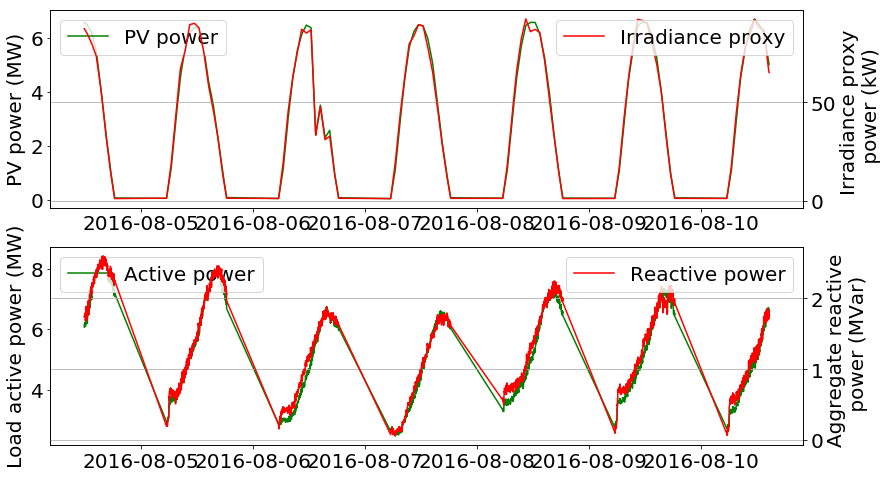

In [10]:
# Plot the dependent variables together with their regressors 
start=2700#1600#2700#1600#15000
finish=7500#5600#7500#5600#len(df)#17000
ax1 = plt.subplot(2,1,1)
ax2 = ax1.twinx()
ax1.plot(df.index[start:finish],df['Real_Power_PV'].iloc[start:finish]/10**3,'-g',label='PV power')
ax2.plot(df.index[start:finish],df['IrradianceProxy'].iloc[start:finish],'-r',label='Irradiance proxy')
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylabel('PV power (MW)',fontsize=20)
ax2.set_ylabel('Irradiance proxy \n power (kW)',fontsize=20)
ax1.legend(prop={'size':20}, loc=2, ncol=1)
ax2.legend(prop={'size':20}, loc=1, ncol=1)
plt.grid()

ax3 = plt.subplot(2,1,2)
ax4 = ax3.twinx()
ax3.plot((df['Real_Power_Total'].iloc[start:finish]+df['Real_Power_PV'].iloc[start:finish])/10**3,'-g',label='Active power')
ax4.plot(df['Reactive_Power_Total'].iloc[start:finish]/10**3,'-r',label='Reactive power')
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax3.set_ylabel('Load active power (MW)',fontsize=20)
ax4.set_ylabel('Aggregate reactive \n power (MVar)',fontsize=20)
ax3.legend(prop={'size':20}, loc=2, ncol=1)
ax4.legend(prop={'size':20}, loc=1, ncol=1)
plt.grid()

fig = plt.gcf()
#fig.tight_layout()
fig.set_size_inches(13.5, 8)
# plt.savefig('data_aug_v3.eps', format='eps', dpi=300)
plt.show()

2.4567132660984976
2114.307042088448


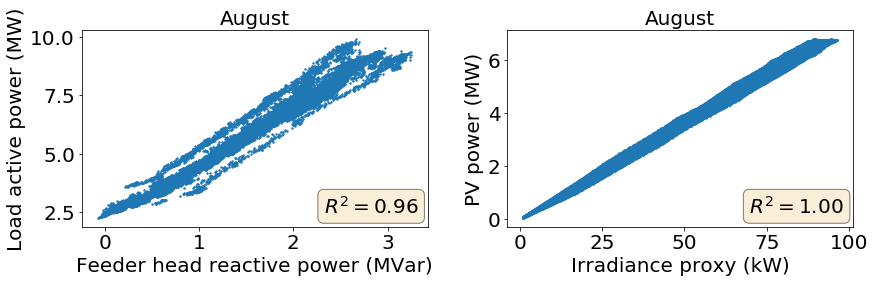

In [11]:
# Corellations between independent and dependent variables
ax = plt.subplot(1,2,1)
plt.scatter(Qagg/1000,loadAct/1000,s=2)
plt.xlabel('Feeder head reactive power (MVar)',fontsize=20)
plt.ylabel('Load active power (MW)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(monthUsed,fontsize=20)
slope, intercept, r_value1, p_value, std_err = stats.linregress(Qagg,loadAct)
textstr = '$R^2=%.2f$' % (r_value1**2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.7, 0.16, textstr, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)
print(slope)
print(intercept)

ax = plt.subplot(1,2,2)
plt.scatter(Irp,-solarAct/1000,s=2)
plt.xlabel('Irradiance proxy (kW)',fontsize=20)
plt.ylabel('PV power (MW)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(monthUsed,fontsize=20)
slope, intercept, r_value2, p_value, std_err = stats.linregress(Irp,-solarAct)
textstr = '$R^2=%.2f$' % (r_value2**2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.7, 0.16, textstr, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)

fig = plt.gcf()
fig.set_size_inches(12.0, 4.0)
plt.tight_layout()
# plt.savefig('scatter_jan_tiny_v2.eps', format='eps', dpi=300)
plt.show()


# Temperature as regressor

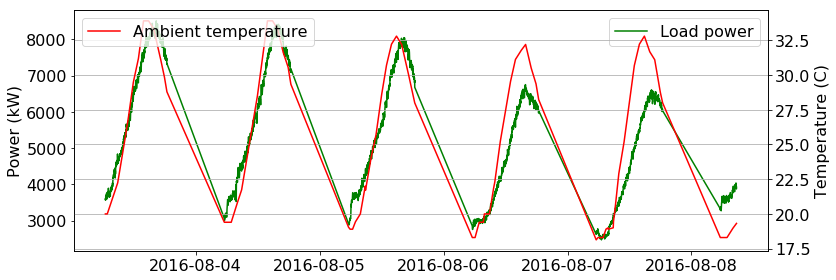

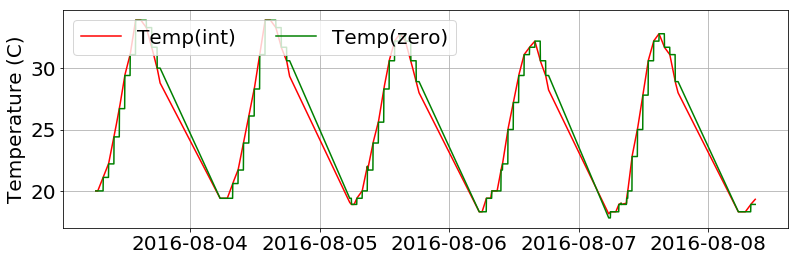

In [12]:
start=1600#0
finish=5600#100000
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot((df['Real_Power_Total'].iloc[start:finish]+df['Real_Power_PV'].iloc[start:finish]),'-g',label='Load power')
ax2.plot(df['Temp(int)'].iloc[start:finish],'-r',label='Ambient temperature')
ax1.set_ylabel('Power (kW)',fontsize=16)
ax2.set_ylabel('Temperature (C)',fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(prop={'size':16}, loc=1, ncol=2)
ax2.legend(prop={'size':16}, loc=2, ncol=2)
fig.tight_layout()
fig.set_size_inches(14, 4)
plt.grid()
plt.show()

plt.plot(df['Temp(int)'].iloc[start:finish],'-r',label='Temp(int)')
plt.plot(df['Temp(zero)'].iloc[start:finish],'-g',label='Temp(zero)')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('Temperature (C)',fontsize=20)
plt.legend(prop={'size':20}, loc=2, ncol=2)
plt.grid()

fig = plt.gcf()
fig.set_size_inches(13, 4)
plt.show()

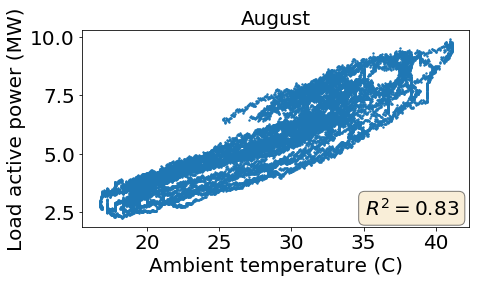

In [13]:
# Corellations between independent and dependent variables
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(df['Temp(int)'],(df['Real_Power_Total']+df['Real_Power_PV'])/10**3,s=2)
plt.xlabel('Ambient temperature (C)',fontsize=20)
plt.ylabel('Load active power (MW)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(monthUsed,fontsize=20)
slope, intercept, r_value1, p_value, std_err = stats.linregress(df['Temp(int)'],(df['Real_Power_Total']+df['Real_Power_PV'])/1000)
textstr = '$R^2=%.2f$' % (r_value1**2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.73, 0.15, textstr, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)

fig = plt.gcf()
fig.set_size_inches(6.5, 4)
plt.tight_layout()
# plt.savefig('scatter_aug_temperature_tiny.eps', format='eps', dpi=300)
plt.show()


# Analysis with distributed PV

Case E, number of proxies 1
It took 4.92300009727 seconds to solve the CSSS problem
MAE (kW): 313.744136383
RMSE (kW): 360.577737767
Normalized RMSE (%, using average load): 6.44277325141
Normalized RMSE (%, using installed PV power): 4.80770317022


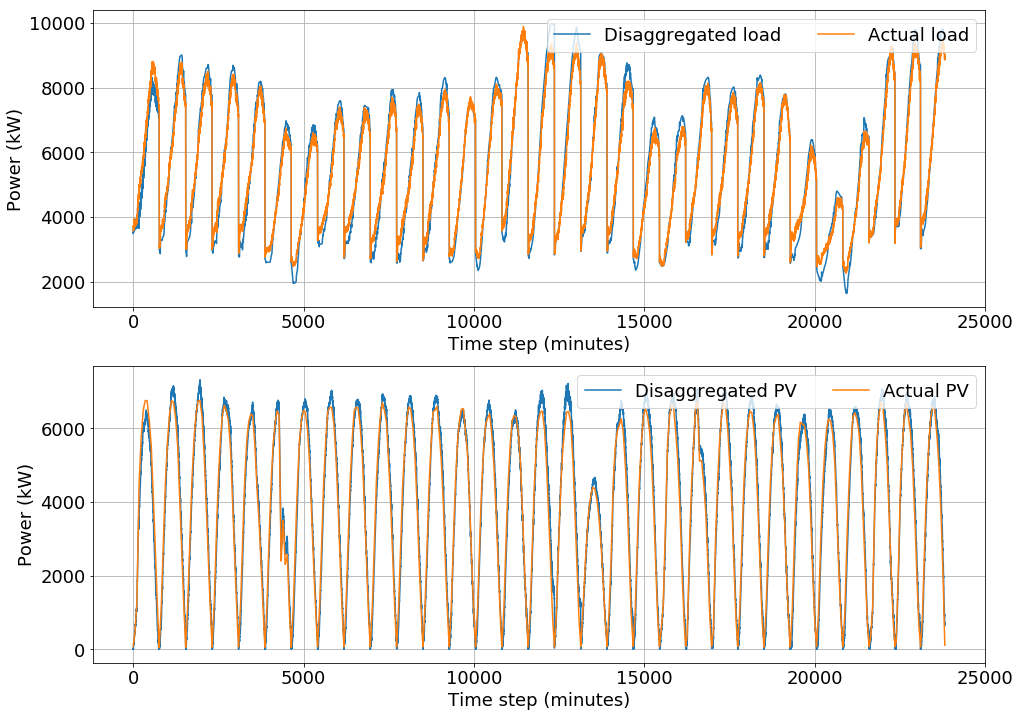

In [14]:
saveRes = False
plotRes = True
proxyLim = 1 # maximum number of proxies to simulate with. In the range [1,len(proxyIDdict.keys())]

# Define data set
dfAux = df
N = len(dfAux)
idxDayChangeAux = idxDayChange
solarActAux = solarAct
loadActAux = loadAct
PVinstalled = 7500 # in kW

numDays = 31
minHour, maxHour = minAndMaxPVhours(dfAux) # minimum and maximum sunshine hours
pvDur = maxHour-minHour

pickle_in = open("proxyIDdict.pickle","rb")
proxyIDdict = pickle.load(pickle_in) # dict with PV systems used as proxies for each scenario of number of proxies

month = monthUsed
simCases = ['E'] #['A','B','C','D','E']

if month=='January': 
    alphaVal = 5
    gammaVal = 5
    betaVal = 0
else:
    alphaVal = 1
    gammaVal = 1.5
    betaVal = 10**6
    
for simCase in simCases:
    if (simCase=='A') | (simCase=='B') | (simCase=='C'):
        Qaux = np.vstack((np.ones((1,N)),np.array(dfAux['Reactive_Power_Total']))).transpose()
    elif (simCase=='D'):
        Qaux = np.vstack((np.ones((1,N)),np.array(dfAux['Reactive_Power_Total']),np.array(dfAux['Temp(int)']))).transpose()
    elif (simCase=='E'):
        numWind = 1 
        windStep = pvDur/numWind
        windEdges = [minHour+k*windStep for k in range(numWind)]
        Qaux1 = buildMat2(dfAux,numDays,'Reactive_Power_Total',1,windEdges,True)
        Qaux2 = buildMat2(dfAux,numDays,'Temp(int)',1,windEdges,False)
        Qaux = np.hstack((Qaux1,Qaux2))

    for key in proxyIDdict.keys():
        if (int(key)>=0) and (int(key)<proxyLim+1):
            listOfProxies = proxyIDdict[key]
            Iraux = np.array([])
            print('Case {}, number of proxies {}'.format(simCase,key))
            if (simCase=='A') | (simCase=='B'):
                idx = 0
                for elem in listOfProxies:
                    if idx==0:
                        Iraux = np.array(dfAux[str(elem)])
                    else:
                        Iraux = np.vstack((Iraux,np.array(dfAux[str(elem)])))
                    idx+=1
                Iraux = Iraux.transpose()
            elif (simCase=='C') | (simCase=='D') | (simCase=='E'):
                if month=='January':
                    numWind = 2
                else:
                    numWind = 3
                windStep = pvDur/numWind
                windEdges = [minHour+k*windStep for k in range(numWind)]
                idx = 0
                for elem in listOfProxies:
                    if idx==0:
                        Iraux = buildMat(dfAux,numDays,str(elem),1,windEdges,False)
                    else:
                        Iraux = np.hstack((Iraux,buildMat(dfAux,numDays,str(elem),1,windEdges,False)))
                    idx+=1

            N=len(dfAux)
            CSSS_solar = CSSS(np.array(dfAux['Real_Power_Total']))  ## Instantiate model with aggregate signal, Y                
            
            if (simCase=='A'):
                CSSS_solar.addSource(Qaux,alpha=alphaVal,name='Load',costFunction='l1')
                CSSS_solar.addSource(Iraux,alpha=1,name='Solar',costFunction='l1')
            elif (simCase=='B'):
                CSSS_solar.addSource(Qaux,alpha=alphaVal,name='Load',costFunction='l1',regularizeTheta='l2',beta=0,regularizeSource='diff_l1',gamma=gammaVal,idxScrReg=idxDayChangeAux)
                CSSS_solar.addSource(Iraux,alpha=1,name='Solar',costFunction='l1',regularizeTheta='l2',beta=0,regularizeSource='diff_l1',gamma=0,idxScrReg=idxDayChangeAux)
            elif (simCase=='C') | (simCase=='D') | (simCase=='E'):
                CSSS_solar.addSource(Qaux,alpha=alphaVal,name='Load',costFunction='l1',regularizeTheta='l2',beta=0,regularizeSource='diff_l1',gamma=gammaVal,idxScrReg=idxDayChangeAux)
                CSSS_solar.addSource(Iraux,alpha=1,name='Solar',costFunction='l1',regularizeTheta='diff_l1',beta=betaVal,numWind=numWind)

            #CSSS_solar = signConst(CSSS_solar,'Solar','Load')
            CSSS_solar = signConst2(CSSS_solar,'Solar','Load')

            start=time.time()
            a=CSSS_solar.constructSolve('MOSEK',False)
            optTime = time.time()-start
            print("It took {} seconds to solve the CSSS problem".format(optTime))

            solarDisag = []
            for val in CSSS_solar.models['Solar']['source'].value:
                solarDisag.append(float(val))
            loadDisag = []
            for val in CSSS_solar.models['Load']['source'].value:
                loadDisag.append(float(val))

            # Error metrics
            MAE = mae(solarActAux,solarDisag)
            RMSE = rmse(solarActAux,solarDisag)
            print("MAE (kW): {}".format(MAE))
            print("RMSE (kW): {}".format(RMSE))
            print("Normalized RMSE (%, using average load): {}".format(100*RMSE/np.average(loadActAux)))
            print("Normalized RMSE (%, using installed PV power): {}".format(100*RMSE/PVinstalled)) 

            if plotRes:
                plt.subplot(2,1,1)
                plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated load')
                plt.plot(np.array(dfAux['Real_Power_Total'])+np.array(dfAux['Real_Power_PV']), label = 'Actual load')
                plt.tick_params(axis='both', which='major', labelsize=18)
                plt.xlabel('Time step (minutes)',fontsize=18)
                plt.ylabel('Power (kW)',fontsize=18)
                plt.grid()
                plt.legend(prop={'size':18}, loc=1, ncol=2)

                plt.subplot(2,1,2)
                plt.plot(-1*CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated PV')
                plt.plot(np.array(dfAux['Real_Power_PV']), label = 'Actual PV')
                plt.tick_params(axis='both', which='major', labelsize=18)
                plt.xlabel('Time step (minutes)',fontsize=18)
                plt.ylabel('Power (kW)',fontsize=18)
                plt.grid()
                plt.legend(prop={'size':18}, loc=1, ncol=2)
                fig = plt.gcf()
                fig.set_size_inches(16, 12)
                plt.show()
            
            if saveRes:
                filename = 'results\\{}_Case_{}_number_of_proxies_{}.json'.format(month,simCase,key)
                resDict = {'solarRegr': CSSS_solar.models['Solar']['theta'].value.tolist(),
                  'loadRegr': CSSS_solar.models['Load']['theta'].value.tolist(),
                  'listOfProxies': listOfProxies.tolist(),
                  'Iraux': Iraux.tolist(),
                  'loadDisag': loadDisag,
                  'solarDisag': solarDisag,
                  'RMSE': RMSE.tolist(),
                  'optTime': optTime}
                with open(filename, 'wb') as f:
                    json.dump(resDict, f) 

In [15]:
# Gather results from simulations with various number of proxies
month = 'August' #'January', 'August'
simCases = ['E'] #['A','B','C','D','E']

num = 10# number of proxies to plot for. In the range [1,len(proxyIDdict.keys())]
RMSE_all=[]
optTime_all = []

for simCase in simCases:
    RMSE=[]
    optTime = []
    for i in range(1,num+1):
        filename = 'results\\{}_Case_{}_number_of_proxies_{}.json'.format(month,simCase,i)
        with open(filename, 'rb') as f:
            resDict = json.load(f)
        RMSE = RMSE + [resDict['RMSE']]
        optTime = optTime + [resDict['optTime']]
    RMSE_all = RMSE_all + [RMSE]
    optTime_all = optTime_all + [optTime] 

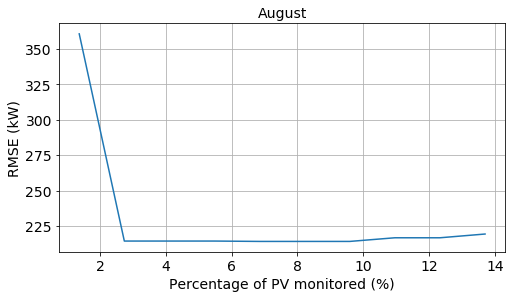

In [16]:
# Plot results from simulations with various number of proxies
fsize=14
PVnum = 73
xticks = 100*(np.arange(1,num+1)/PVnum)

for row in range(0,len(RMSE_all)):
    plt.plot(xticks,RMSE_all[row],label='Case '+simCases[row])
    plt.xlabel('Percentage of PV monitored (%)',fontsize=fsize)
    plt.ylabel('RMSE (kW)',fontsize=fsize)
plt.grid()
plt.title(month,fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
fig = plt.gcf()
fig.set_size_inches(8,4.2)
# plt.savefig('distributed_PV_number_proxies.eps',format='eps',dpi=300)
plt.show()